# Sentiment Analysis with Deep Learning using BERT

### Project Outline

**Step 1**: Introduction (this section)

**Step 2**: Exploratory Data Analysis and Preprocessing

**Step 3**: Training/Validation Split

**Step 4**: Loading Tokenizer and Encoding our Data

**Step 5**: Setting up BERT Pretrained Model

**Step 6**: Creating Data Loaders

**Step 7**: Setting Up Optimizer and Scheduler

**Step 8**: Defining our Performance Metrics

**Step 9**: Creating our Training Loop

## Introduction

### What is BERT

BERT is a large-scale transformer-based Language Model that can be finetuned for a variety of tasks.

For more information, the original paper can be found [here](https://arxiv.org/abs/1810.04805).

[HuggingFace documentation](https://huggingface.co/transformers/model_doc/bert.html)

[Bert documentation](https://characters.fandom.com/wiki/Bert_(Sesame_Street) ;)

<img src="Images/BERT_diagrams.pdf" width="1000">

## Exploratory Data Analysis and Preprocessing

We will use the SMILE Twitter dataset.

_Wang, Bo; Tsakalidis, Adam; Liakata, Maria; Zubiaga, Arkaitz; Procter, Rob; Jensen, Eric (2016): SMILE Twitter Emotion dataset. figshare. Dataset. https://doi.org/10.6084/m9.figshare.3187909.v2_

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
def load_and_explore_data(file_path='/content/smile-annotations-final.csv'):
    """Load data and perform initial exploration"""

    df = pd.read_csv(file_path, names=['id', 'text', 'category'])
    df.set_index('id', inplace=True)

    print(f"Dataset shape: {df.shape}")
    print(f"Categories: {df.category.unique()}")

    return df

In [3]:
df = load_and_explore_data(file_path='/content/smile-annotations-final.csv')

Dataset shape: (3085, 2)
Categories: ['nocode' 'happy' 'not-relevant' 'angry' 'disgust|angry' 'disgust'
 'happy|surprise' 'sad' 'surprise' 'happy|sad' 'sad|disgust' 'sad|angry'
 'sad|disgust|angry']


In [4]:
df.category.value_counts()

,count
category,
nocode,1572
happy,1137
not-relevant,214
angry,57
surprise,35
sad,32
happy|surprise,11
happy|sad,9
disgust|angry,7


In [5]:
def clean_data(df):
    print("Cleaning data...")

    df_clean = df[~df.category.str.contains('\\|')].copy()
    print(f"Removed {len(df) - len(df_clean)} entries with multiple labels")

    # Removing 'nocode' category
    df_clean = df_clean[df_clean.category != 'nocode']
    print(f"Removed 'nocode' entries. New shape: {df_clean.shape}")

    # Creating label mappings
    possible_labels = df_clean.category.unique()
    label_dict = {label: idx for idx, label in enumerate(possible_labels)}
    df_clean['label'] = df_clean.category.replace(label_dict)

    print(f"Label mapping: {label_dict}")

    return df_clean, label_dict

In [6]:
df_clean, label_dict = clean_data(df)

Cleaning data...
Removed 32 entries with multiple labels
Removed 'nocode' entries. New shape: (1481, 2)
Label mapping: {'happy': 0, 'not-relevant': 1, 'angry': 2, 'disgust': 3, 'sad': 4, 'surprise': 5}


In [7]:
def perform_eda(df, label_dict):
    """Perform comprehensive exploratory data analysis"""
    print("Performing Exploratory Data Analysis...")

    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))

    # 1. Class Distribution
    ax1 = plt.subplot(2, 3, 1)
    class_counts = df.category.value_counts()
    colors = sns.color_palette("husl", len(class_counts))
    bars = ax1.bar(class_counts.index, class_counts.values, color=colors)
    plt.title('Distribution of Sentiment Classes', fontsize=14, fontweight='bold')
    plt.xlabel('Sentiment Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{int(height)}', ha='center', va='bottom')

    # 2. Text Length Distribution
    ax2 = plt.subplot(2, 3, 2)
    df['text_length'] = df['text'].str.len()
    ax2.hist(df['text_length'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Distribution of Text Lengths', fontsize=14, fontweight='bold')
    plt.xlabel('Text Length (characters)')
    plt.ylabel('Frequency')
    plt.axvline(df['text_length'].mean(), color='red', linestyle='--',
                label=f'Mean: {df["text_length"].mean():.1f}')
    plt.legend()

    # 3. Word Count Distribution
    ax3 = plt.subplot(2, 3, 3)
    df['word_count'] = df['text'].str.split().str.len()
    ax3.hist(df['word_count'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.title('Distribution of Word Counts', fontsize=14, fontweight='bold')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.axvline(df['word_count'].mean(), color='red', linestyle='--',
                label=f'Mean: {df["word_count"].mean():.1f}')
    plt.legend()

    # 4. Text Length by Category
    ax4 = plt.subplot(2, 3, 4)
    df.boxplot(column='text_length', by='category', ax=ax4)
    plt.title('Text Length Distribution by Category')
    plt.suptitle('')  # Remove the automatic title
    plt.xticks(rotation=45)

    # 5. Word Count by Category
    ax5 = plt.subplot(2, 3, 5)
    df.boxplot(column='word_count', by='category', ax=ax5)
    plt.title('Word Count Distribution by Category')
    plt.suptitle('')  # Remove the automatic title
    plt.xticks(rotation=45)

    # 6. Class Balance Pie Chart
    ax6 = plt.subplot(2, 3, 6)
    class_counts.plot(kind='pie', ax=ax6, autopct='%1.1f%%', startangle=90)
    plt.title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')
    plt.ylabel('')  # Remove y-label for pie chart

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\n Dataset Statistics:")
    print(f"Total samples: {len(df)}")
    print(f"Average text length: {df['text_length'].mean():.1f} characters")
    print(f"Average word count: {df['word_count'].mean():.1f} words")
    print(f"Most common category: {class_counts.index[0]} ({class_counts.iloc[0]} samples)")
    print(f"Class imbalance ratio: {class_counts.max() / class_counts.min():.1f}:1")

    return df

Performing Exploratory Data Analysis...


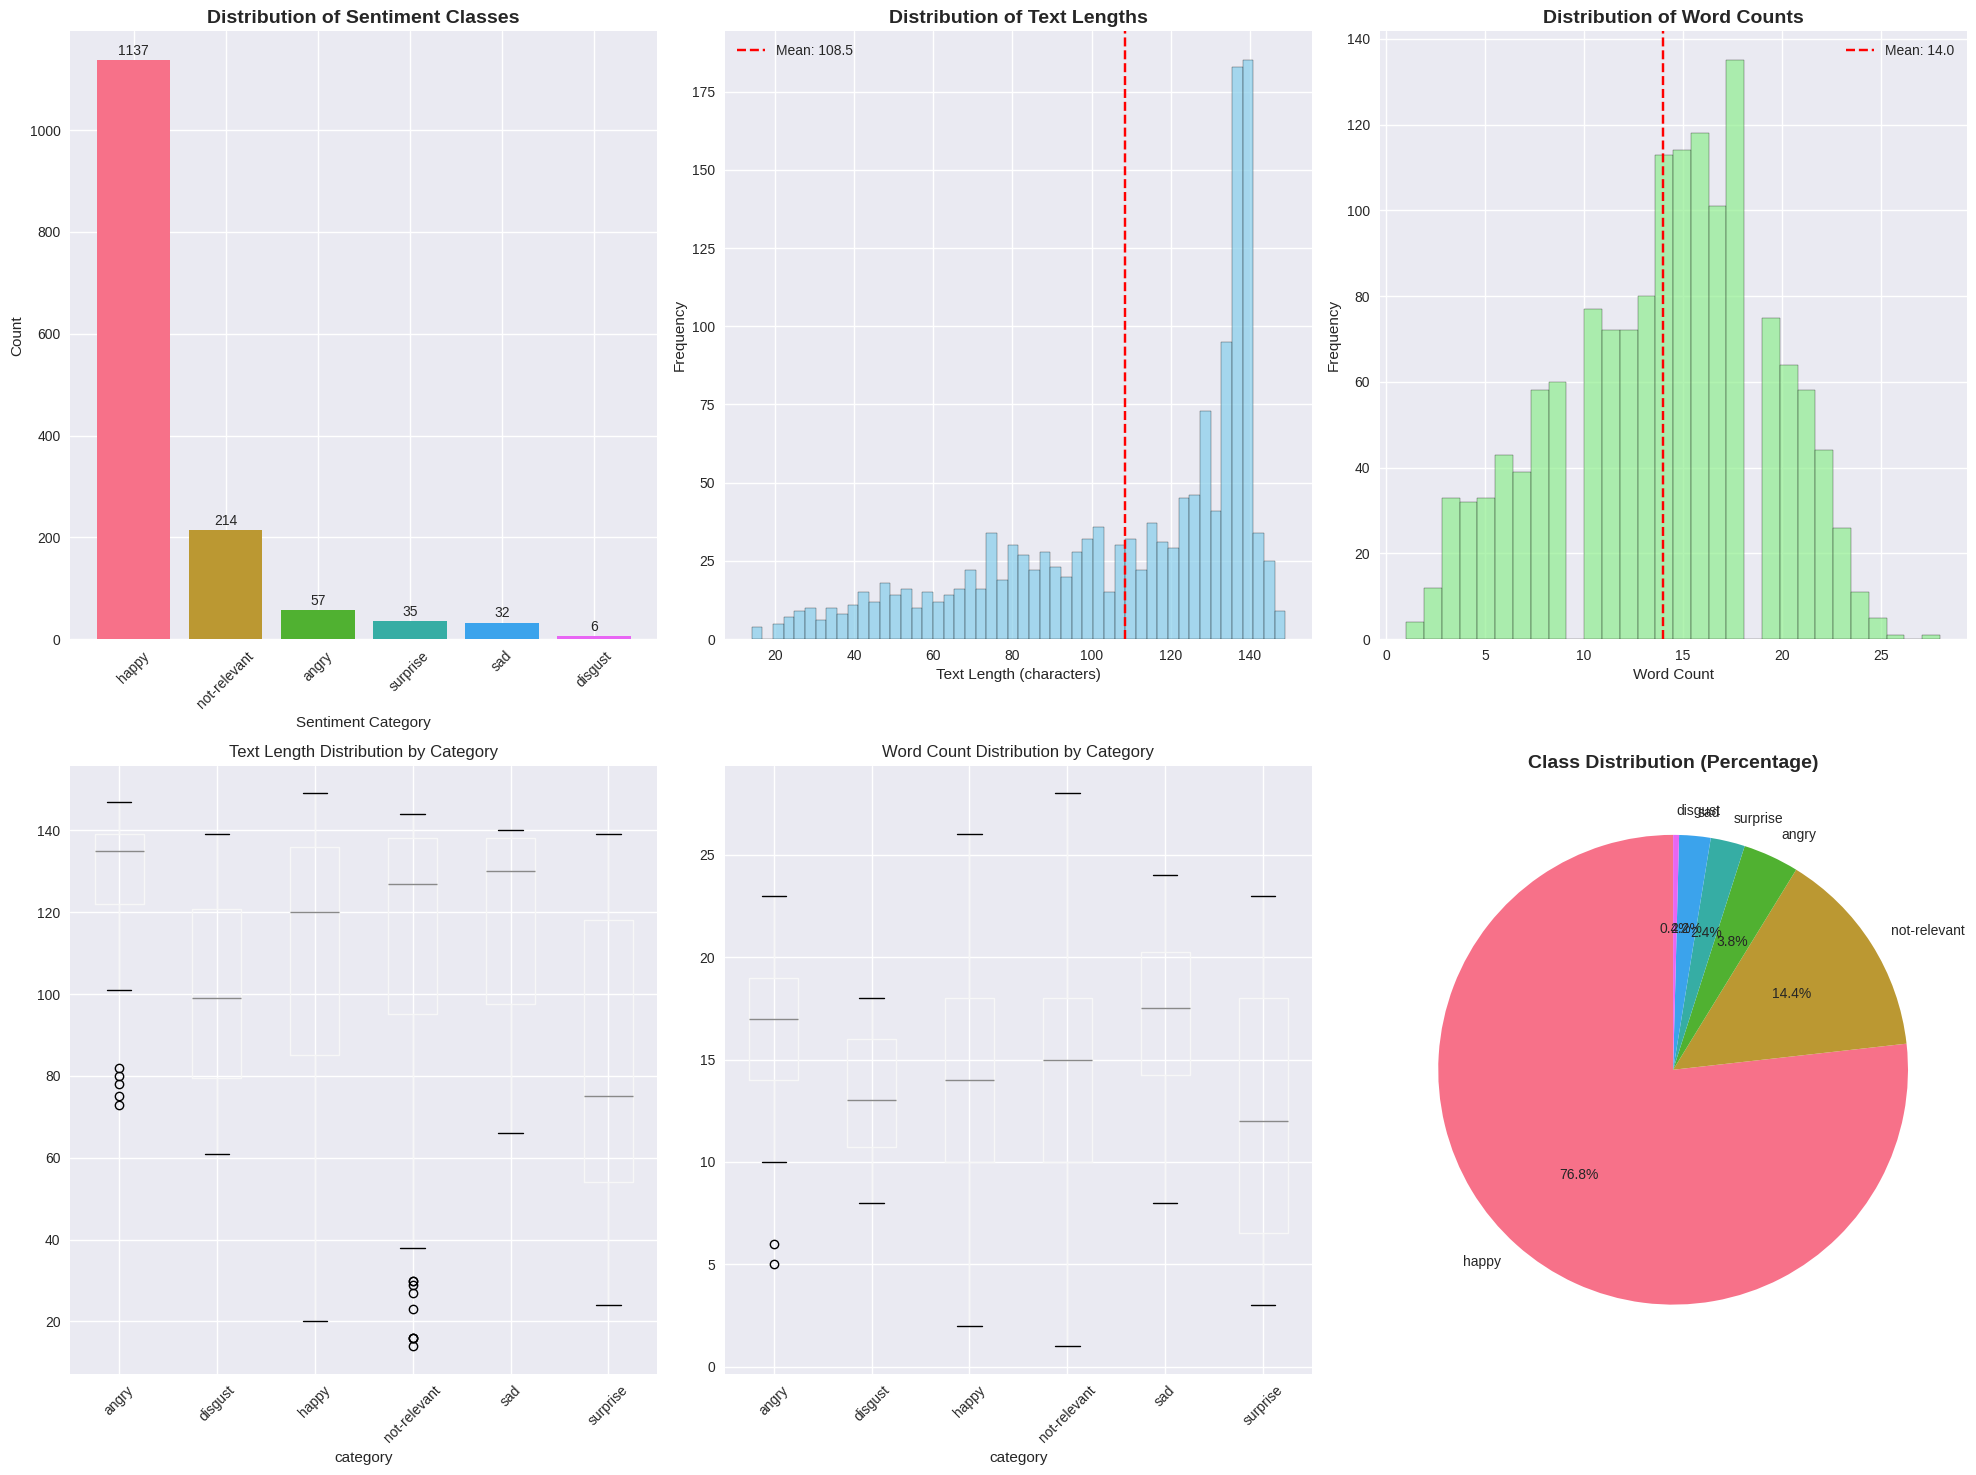


 Dataset Statistics:
Total samples: 1481
Average text length: 108.5 characters
Average word count: 14.0 words
Most common category: happy (1137 samples)
Class imbalance ratio: 189.5:1


In [8]:
df_new = perform_eda(df_clean, label_dict)

In [9]:
def analyze_text_samples(df):
    """Analyze sample texts from each category"""
    print("\n Sample texts from each category:")
    for category in df.category.unique():
        print(f"\n{category.upper()}:")
        samples = df[df.category == category].text.head(3)
        for i, text in enumerate(samples, 1):
            print(f"  {i}. {text[:100]}...")

In [10]:
analyze_text_samples(df_new)


 Sample texts from each category:

HAPPY:
  1. Dorian Gray with Rainbow Scarf #LoveWins (from @britishmuseum http://t.co/Q4XSwL0esu) http://t.co/h0...
  2. @SelectShowcase @Tate_StIves ... Replace with your wish which the artist uses in next installation! ...
  3. @Sofabsports thank you for following me back. Great to hear from a diverse &amp; interesting panel #...

NOT-RELEVANT:
  1. @RAMMuseum Please vote for us as @sainsbury #sidwell's local charity PRT http://t.co/IguyWk5MJT http...
  2. #AskTheGallery Have you got plans to privatise any other roles @NationalGallery ?...
  3. Over 100 people signed up for 'What's It Worth?' @britishmuseum! Don't miss out, book now! #cdavalue...

ANGRY:
  1. @nationalgallery #AskTheGallery Why do you pay your brilliant staff so poorly?...
  2. . @NationalGallery What message does oil sponsorship of the arts send to those ngotiating a climate ...
  3. .@IanLaveryMP can you attend adjournment debate tomorrow #noprivatisation @NationalGallery #reinst

## Training/Validation Split

In [11]:
def create_train_val_split(df, test_size=0.15, random_state=42):
    """Create stratified train/validation split with visualization"""
    from sklearn.model_selection import train_test_split

    print("Creating train/validation split...")

    X_train, X_val, y_train, y_val = train_test_split(
        df.index.values,
        df.label.values,
        test_size=test_size,
        random_state=random_state,
        stratify=df.label.values
    )

    # Add data_type column
    df['data_type'] = 'not_set'
    df.loc[X_train, 'data_type'] = 'train'
    df.loc[X_val, 'data_type'] = 'val'

    # Visualize split
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Training set distribution
    train_counts = df[df.data_type == 'train'].category.value_counts()
    ax1.bar(train_counts.index, train_counts.values, alpha=0.7, color='blue')
    ax1.set_title('Training Set Distribution', fontweight='bold')
    ax1.set_xlabel('Category')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)

    # Validation set distribution
    val_counts = df[df.data_type == 'val'].category.value_counts()
    ax2.bar(val_counts.index, val_counts.values, alpha=0.7, color='orange')
    ax2.set_title('Validation Set Distribution', fontweight='bold')
    ax2.set_xlabel('Category')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Print split statistics
    split_stats = df.groupby(['category', 'label', 'data_type']).size().unstack(fill_value=0)
    print("\n Train/Validation Split Summary:")
    print(split_stats)

    return df

Creating train/validation split...


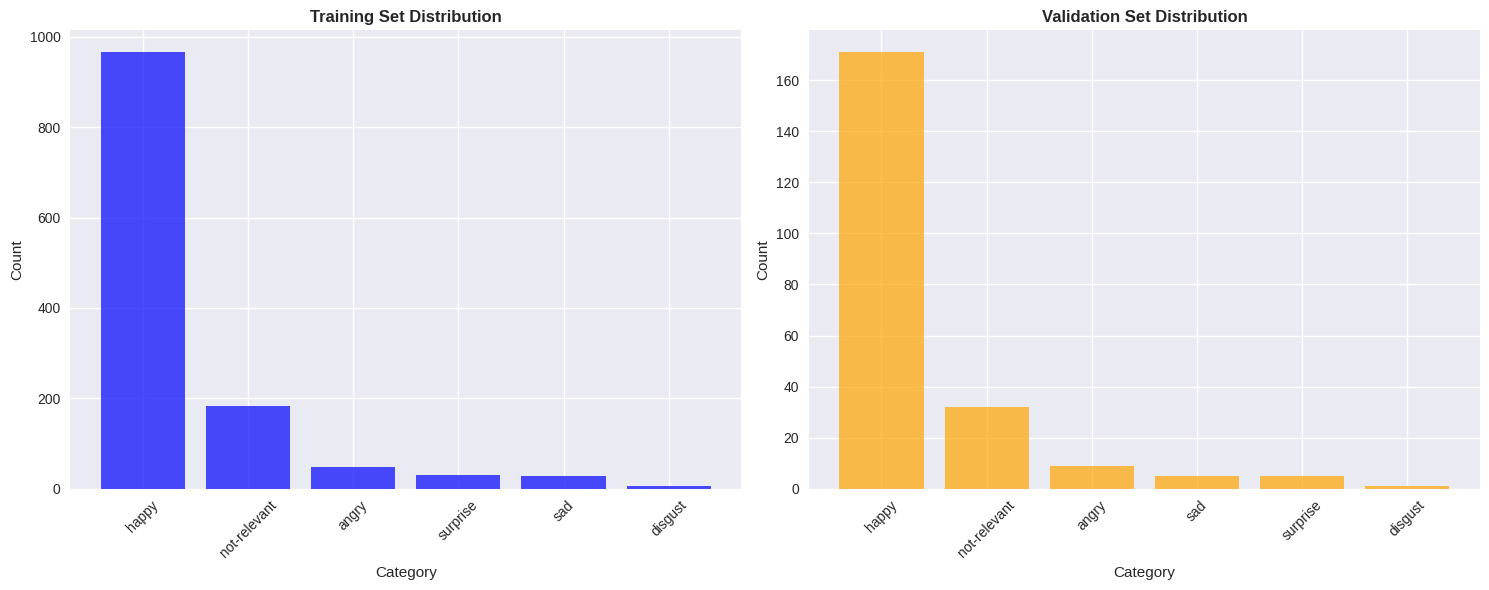


 Train/Validation Split Summary:
data_type           train  val
category     label            
angry        2         48    9
disgust      3          5    1
happy        0        966  171
not-relevant 1        182   32
sad          4         27    5
surprise     5         30    5


In [12]:
df_new = create_train_val_split(df_new)

## Loading Tokenizer and Encoding our Data

In [13]:
def encode_data(df, tokenizer, max_length=256):
    """Encode data with progress tracking and statistics"""
    from torch.utils.data import TensorDataset

    print("Encoding text data...")

    # Encode training data
    train_texts = df[df.data_type=='train'].text.values
    encoded_data_train = tokenizer.batch_encode_plus(
        train_texts,
        add_special_tokens=True,
        return_attention_mask=True,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt'
    )

    # Encode validation data
    val_texts = df[df.data_type=='val'].text.values
    encoded_data_val = tokenizer.batch_encode_plus(
        val_texts,
        add_special_tokens=True,
        return_attention_mask=True,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt'
    )

    # Create tensors
    input_ids_train = encoded_data_train['input_ids']
    attention_masks_train = encoded_data_train['attention_mask']
    labels_train = torch.tensor(df[df.data_type=='train'].label.values)

    input_ids_val = encoded_data_val['input_ids']
    attention_masks_val = encoded_data_val['attention_mask']
    labels_val = torch.tensor(df[df.data_type=='val'].label.values)

    # Create datasets
    dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
    dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

    print(f"   Encoding complete:")
    print(f"   Training samples: {len(dataset_train)}")
    print(f"   Validation samples: {len(dataset_val)}")
    print(f"   Max sequence length: {max_length}")

    return dataset_train, dataset_val

In [14]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
dataset_train, dataset_val = encode_data(df_new, tokenizer, max_length=256)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Encoding text data...
   Encoding complete:
   Training samples: 1258
   Validation samples: 223
   Max sequence length: 256


## Setting up BERT Pretrained Model

In [15]:
class TrainingLogger:
    """Class to log and visualize training progress"""

    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.val_f1_scores = []
        self.val_accuracies = []

    def log_epoch(self, train_loss, val_loss, val_f1, val_acc):
        """Log metrics for an epoch"""
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.val_f1_scores.append(val_f1)
        self.val_accuracies.append(val_acc)

    def plot_training_history(self):
        """Plot comprehensive training history"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        epochs = range(1, len(self.train_losses) + 1)

        # Plot losses
        axes[0, 0].plot(epochs, self.train_losses, 'b-o', label='Training Loss', linewidth=2)
        axes[0, 0].plot(epochs, self.val_losses, 'r-o', label='Validation Loss', linewidth=2)
        axes[0, 0].set_title('Training and Validation Loss', fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Plot F1 scores
        axes[0, 1].plot(epochs, self.val_f1_scores, 'g-o', label='Validation F1', linewidth=2)
        axes[0, 1].set_title('Validation F1 Score', fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('F1 Score')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Plot accuracies
        axes[1, 0].plot(epochs, self.val_accuracies, 'm-o', label='Validation Accuracy', linewidth=2)
        axes[1, 0].set_title('Validation Accuracy', fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Accuracy')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # Plot learning curves comparison
        ax = axes[1, 1]
        ax2 = ax.twinx()

        line1 = ax.plot(epochs, self.train_losses, 'b-', label='Train Loss', linewidth=2)
        line2 = ax.plot(epochs, self.val_losses, 'r-', label='Val Loss', linewidth=2)
        line3 = ax2.plot(epochs, self.val_f1_scores, 'g--', label='Val F1', linewidth=2)

        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss', color='black')
        ax2.set_ylabel('F1 Score', color='green')

        # Combine legends
        lines = line1 + line2 + line3
        labels = [l.get_label() for l in lines]
        ax.legend(lines, labels, loc='center right')
        ax.set_title('Training Overview', fontweight='bold')
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

In [16]:
from transformers import BertForSequenceClassification

In [17]:
model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels=len(label_dict),
        output_attentions=False,
        output_hidden_states=False
    )

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Creating Data Loaders

In [19]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [20]:
batch_size = 32
dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)
dataloader_val = DataLoader(
    dataset_val,
    sampler=SequentialSampler(dataset_val),
    batch_size=batch_size
)

## Setting Up Optimiser and Scheduler

In [21]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

In [22]:
def enhanced_evaluate(model, dataloader_val, device):
    """Enhanced evaluation with detailed metrics"""
    from sklearn.metrics import f1_score, accuracy_score

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)

        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2],
        }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total / len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    # Calculate metrics
    preds_flat = np.argmax(predictions, axis=1)
    f1 = f1_score(true_vals, preds_flat, average='weighted')
    accuracy = accuracy_score(true_vals, preds_flat)

    return loss_val_avg, predictions, true_vals, f1, accuracy

In [23]:
def train_model_enhanced(model, dataloader_train, dataloader_val, optimizer, scheduler,
                        device, epochs=3, model_name="bert_sentiment"):
    """Enhanced training loop with comprehensive logging and visualization"""
    from sklearn.metrics import f1_score
    import os

    # Initialize logger
    logger = TrainingLogger()

    # Create models directory
    os.makedirs('Models', exist_ok=True)

    print("🚀 Starting enhanced training...")

    for epoch in tqdm(range(1, epochs + 1)):
        # Training phase
        model.train()
        loss_train_total = 0

        progress_bar = tqdm(dataloader_train, desc=f'Epoch {epoch}', leave=False)
        for batch in progress_bar:
            model.zero_grad()

            batch = tuple(b.to(device) for b in batch)

            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2],
            }

            outputs = model(**inputs)

            loss = outputs[0]
            loss_train_total += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            progress_bar.set_postfix({
                'train_loss': f'{loss.item()/len(batch):.3f}'
            })

        # Save model checkpoint
        torch.save(model.state_dict(), f'Models/{model_name}_epoch_{epoch}.model')

        # Validation phase
        loss_train_avg = loss_train_total / len(dataloader_train)
        val_loss, predictions, true_vals, val_f1, val_accuracy = enhanced_evaluate(
            model, dataloader_val, device
        )

        # Log metrics
        logger.log_epoch(loss_train_avg, val_loss, val_f1, val_accuracy)

        # Print epoch results
        print(f'\n Epoch {epoch} Results:')
        print(f'   Training Loss: {loss_train_avg:.4f}')
        print(f'   Validation Loss: {val_loss:.4f}')
        print(f'   Validation F1: {val_f1:.4f}')
        print(f'   Validation Accuracy: {val_accuracy:.4f}')

    # Plot training history
    logger.plot_training_history()

    return model, logger

In [24]:
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 5
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) * epochs
)

🚀 Starting enhanced training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]


 Epoch 1 Results:
   Training Loss: 0.5745
   Validation Loss: 0.6048
   Validation F1: 0.7475
   Validation Accuracy: 0.8072


Epoch 2:   0%|          | 0/40 [00:00<?, ?it/s]


 Epoch 2 Results:
   Training Loss: 0.5712
   Validation Loss: 0.6048
   Validation F1: 0.7475
   Validation Accuracy: 0.8072


Epoch 3:   0%|          | 0/40 [00:00<?, ?it/s]


 Epoch 3 Results:
   Training Loss: 0.5646
   Validation Loss: 0.6048
   Validation F1: 0.7475
   Validation Accuracy: 0.8072


Epoch 4:   0%|          | 0/40 [00:00<?, ?it/s]


 Epoch 4 Results:
   Training Loss: 0.5665
   Validation Loss: 0.6048
   Validation F1: 0.7475
   Validation Accuracy: 0.8072


Epoch 5:   0%|          | 0/40 [00:00<?, ?it/s]


 Epoch 5 Results:
   Training Loss: 0.5632
   Validation Loss: 0.6048
   Validation F1: 0.7475
   Validation Accuracy: 0.8072


Epoch 6:   0%|          | 0/40 [00:00<?, ?it/s]


 Epoch 6 Results:
   Training Loss: 0.5757
   Validation Loss: 0.6048
   Validation F1: 0.7475
   Validation Accuracy: 0.8072


Epoch 7:   0%|          | 0/40 [00:00<?, ?it/s]


 Epoch 7 Results:
   Training Loss: 0.5632
   Validation Loss: 0.6048
   Validation F1: 0.7475
   Validation Accuracy: 0.8072


Epoch 8:   0%|          | 0/40 [00:00<?, ?it/s]


 Epoch 8 Results:
   Training Loss: 0.5695
   Validation Loss: 0.6048
   Validation F1: 0.7475
   Validation Accuracy: 0.8072


Epoch 9:   0%|          | 0/40 [00:00<?, ?it/s]


 Epoch 9 Results:
   Training Loss: 0.5659
   Validation Loss: 0.6048
   Validation F1: 0.7475
   Validation Accuracy: 0.8072


Epoch 10:   0%|          | 0/40 [00:00<?, ?it/s]


 Epoch 10 Results:
   Training Loss: 0.5605
   Validation Loss: 0.6048
   Validation F1: 0.7475
   Validation Accuracy: 0.8072


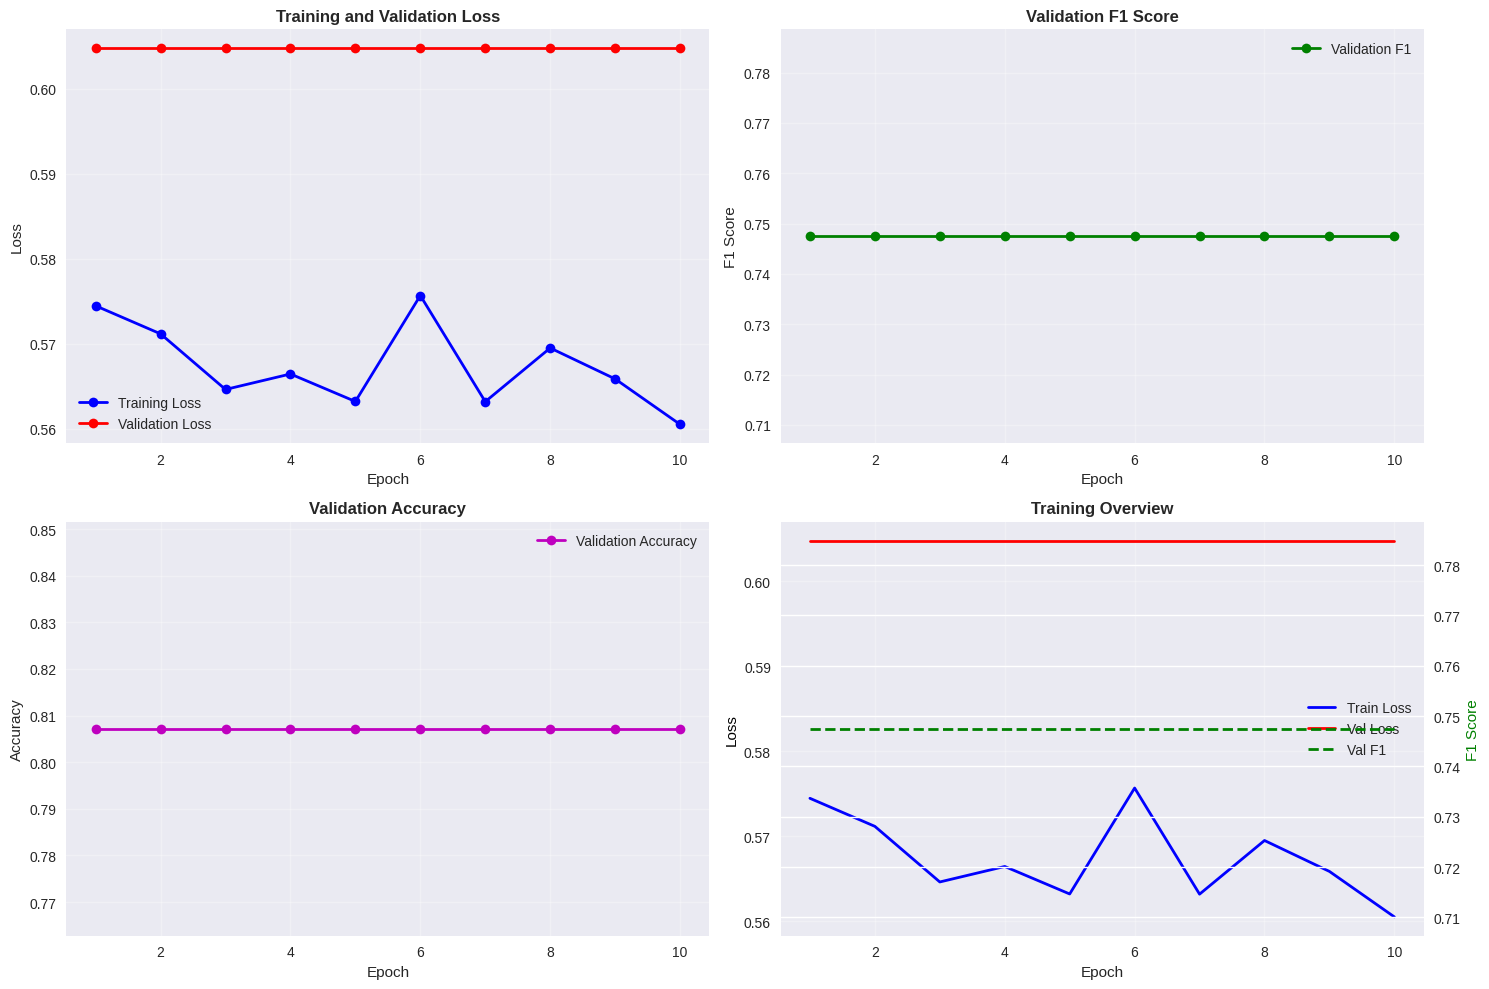

In [31]:
trained_model, logger = train_model_enhanced(
        model, dataloader_train, dataloader_val,
        optimizer, scheduler, device, epochs=10
    )

## Defining our Performance Metrics

Accuracy metric approach originally used in accuracy function in [this tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification).

In [32]:
print("\n Final Model Evaluation")
print("=" * 30)

_, predictions, true_vals, final_f1, final_accuracy = enhanced_evaluate(
        trained_model, dataloader_val, device
    )

print(f"Final Validation F1 Score: {final_f1:.4f}")
print(f"Final Validation Accuracy: {final_accuracy:.4f}")


 Final Model Evaluation
Final Validation F1 Score: 0.7475
Final Validation Accuracy: 0.8072


## Creating our Training Loop

In [33]:
def plot_confusion_matrix(predictions, true_vals, label_dict):
    """Plot detailed confusion matrix"""
    from sklearn.metrics import confusion_matrix, classification_report
    import itertools

    # Create inverse label mapping
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    # Get predictions
    preds_flat = np.argmax(predictions, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(true_vals, preds_flat)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.colorbar()

    # Add labels
    tick_marks = np.arange(len(label_dict))
    plt.xticks(tick_marks, [label_dict_inverse[i] for i in range(len(label_dict))], rotation=45)
    plt.yticks(tick_marks, [label_dict_inverse[i] for i in range(len(label_dict))])

    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label', fontweight='bold')
    plt.xlabel('Predicted Label', fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("\n Detailed Classification Report:")
    class_names = [label_dict_inverse[i] for i in range(len(label_dict))]
    print(classification_report(true_vals, preds_flat, target_names=class_names))

In [34]:
def plot_per_class_accuracy(predictions, true_vals, label_dict):
    """Plot per-class accuracy with detailed statistics"""
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(predictions, axis=1)

    class_accuracies = []
    class_names = []
    class_counts = []

    for label in np.unique(true_vals):
        y_preds = preds_flat[true_vals == label]
        y_true = true_vals[true_vals == label]
        accuracy = len(y_preds[y_preds == label]) / len(y_true)

        class_accuracies.append(accuracy)
        class_names.append(label_dict_inverse[label])
        class_counts.append(len(y_true))

        print(f'{label_dict_inverse[label]}: {len(y_preds[y_preds==label])}/{len(y_true)} ({accuracy:.3f})')

    # Plot per-class accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Accuracy bar plot
    bars = ax1.bar(class_names, class_accuracies, color=sns.color_palette("husl", len(class_names)))
    ax1.set_title('Per-Class Accuracy', fontweight='bold')
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1)

    # Add value labels on bars
    for bar, acc in zip(bars, class_accuracies):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc:.3f}', ha='center', va='bottom')

    # Sample count vs accuracy scatter plot
    ax2.scatter(class_counts, class_accuracies, s=100, alpha=0.7)
    for i, name in enumerate(class_names):
        ax2.annotate(name, (class_counts[i], class_accuracies[i]),
                    xytext=(5, 5), textcoords='offset points')

    ax2.set_xlabel('Number of Samples')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Sample Count vs Accuracy', fontweight='bold')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

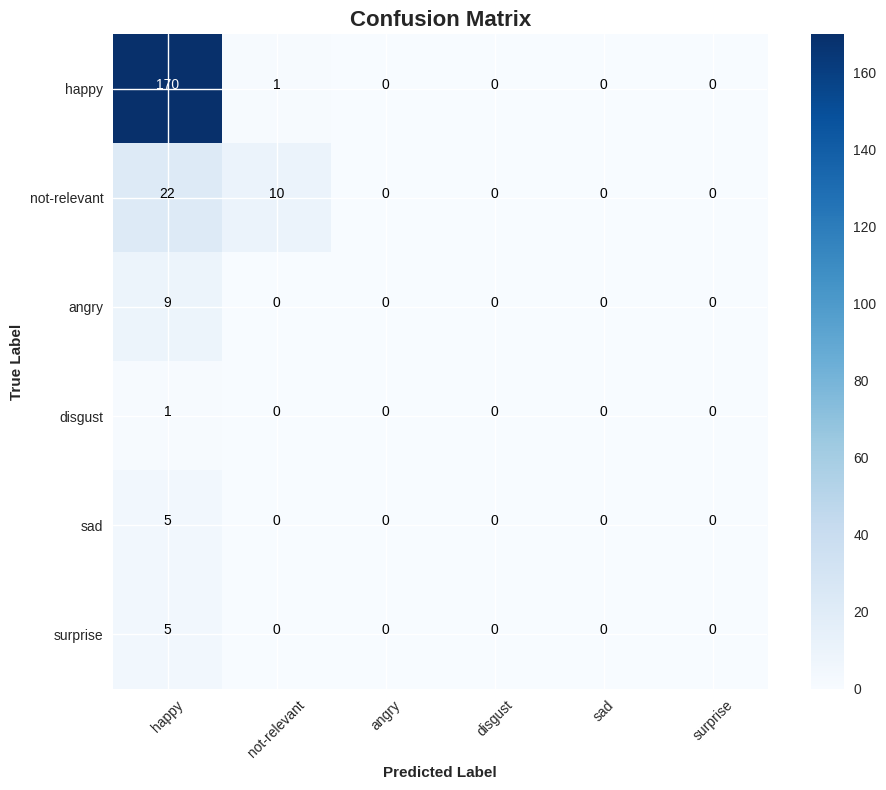


 Detailed Classification Report:
              precision    recall  f1-score   support

       happy       0.80      0.99      0.89       171
not-relevant       0.91      0.31      0.47        32
       angry       0.00      0.00      0.00         9
     disgust       0.00      0.00      0.00         1
         sad       0.00      0.00      0.00         5
    surprise       0.00      0.00      0.00         5

    accuracy                           0.81       223
   macro avg       0.29      0.22      0.23       223
weighted avg       0.75      0.81      0.75       223



In [35]:
plot_confusion_matrix(predictions, true_vals, label_dict)

happy: 170/171 (0.994)
not-relevant: 10/32 (0.312)
angry: 0/9 (0.000)
disgust: 0/1 (0.000)
sad: 0/5 (0.000)
surprise: 0/5 (0.000)


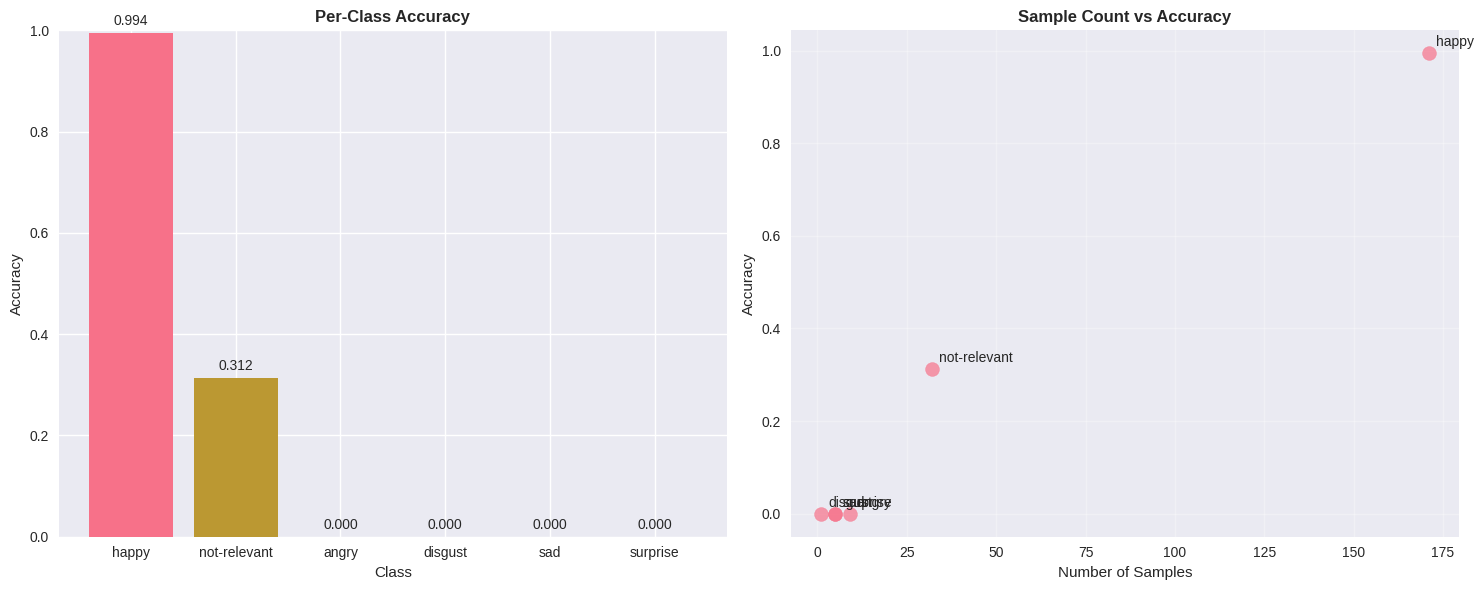

In [36]:
plot_per_class_accuracy(predictions, true_vals, label_dict)

In [ ]:
!zip -r models.zip /content/Models/

  adding: content/Models/ (stored 0%)
  adding: content/Models/bert_sentiment_epoch_8.model (deflated 7%)
  adding: content/Models/bert_sentiment_epoch_4.model (deflated 7%)
  adding: content/Models/bert_sentiment_epoch_1.model (deflated 7%)
  adding: content/Models/bert_sentiment_epoch_6.model (deflated 7%)
  adding: content/Models/bert_sentiment_epoch_5.model (deflated 7%)
  adding: content/Models/bert_sentiment_epoch_2.model (deflated 7%)
  adding: content/Models/bert_sentiment_epoch_9.model (deflated 7%)
  adding: content/Models/bert_sentiment_epoch_7.model (deflated 7%)
  adding: content/Models/bert_sentiment_epoch_10.model